In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [2]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [3]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dataset imdb_reviews downloaded and prepared to /Users/dongdong/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [5]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

In [7]:
train_examples_batch[:3]

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [6]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862679,  0.7753425 , -0.07667089,
        -0.15752277,  0.01872335, -0.08169781, -0.3521876 ,  0.4637341 ,
        -0.08492756,  0.07166859, -0.00670817,  0.12686075, -0.19326553,
 

In [11]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 16)                816       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [12]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense_8 (Dense)             (None, 16)                816       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 29s 885ms/step - loss: 0.6983 - accuracy: 0.4953 - val_loss: 0.6526 - val_accuracy: 0.5322
Epoch 2/10
30/30 [==============================] - 28s 934ms/step - loss: 0.6073 - accuracy: 0.6165 - val_loss: 0.5725 - val_accuracy: 0.6806
Epoch 3/10
30/30 [==============================] - 31s 1s/step - loss: 0.4963 - accuracy: 0.7553 - val_loss: 0.4695 - val_accuracy: 0.7874
Epoch 4/10
30/30 [==============================] - 31s 1s/step - loss: 0.3720 - accuracy: 0.8555 - val_loss: 0.3846 - val_accuracy: 0.8292
Epoch 5/10
30/30 [==============================] - 31s 1s/step - loss: 0.2725 - accuracy: 0.9061 - val_loss: 0.3344 - val_accuracy: 0.8568
Epoch 6/10
30/30 [==============================] - 27s 893ms/step - loss: 0.2027 - accuracy: 0.9324 - val_loss: 0.3106 - val_accuracy: 0.8615
Epoch 7/10
30/30 [==============================] - 27s 884ms/step - loss: 0.1519 - accuracy: 0.9543 - val_loss: 0.3007 - val_accuracy: 0.8684
Epoch 8/

In [21]:
import matplotlib.pyplot as plt

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

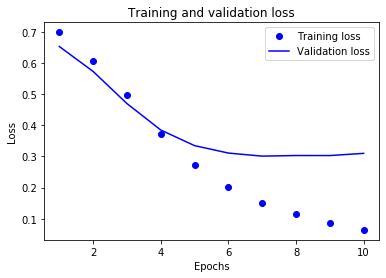

In [23]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

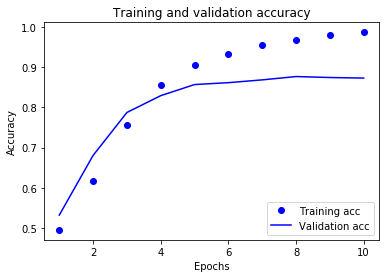

In [24]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()